<hr>
<h2> 0. Global Constance & Variable</h2>
Config global values
<hr>

In [116]:
_DATASET_ADDRESS_ = './dataset/'
_PICKLE_ADDRESS_ = './pickle/'
_K_ = 6
_TOP_N_PRUN_ = 10

_DELTA_ = 0.00005

In [117]:
#기본 라이브러리
import pandas as pd
import numpy as np
import math
import time
import pickle
import nashpy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

tqdm.pandas()

# SVD 행렬축소
from sklearn.decomposition import TruncatedSVD

# 제작 함수
import func

In [118]:

#데이터 불러오기
ratings = pd.read_csv("u.data.txt", header=None, sep='\t')
ratings.columns = ['userid','movieid','rating','timestamp']
ratings = ratings.drop(['timestamp'], axis=1)
print("총 주어진 ratings 데이터 : ", ratings.shape)
rating_table= pd.pivot_table(ratings, values='rating', index=['userid'], columns=['movieid'])

총 주어진 ratings 데이터 :  (100000, 3)


In [119]:
# 80000 row
user_train_raw = pd.read_csv(_DATASET_ADDRESS_ + 'u1.base', sep='\t',names=["userID","itemID","rating","timestamp"],header=None, na_filter=False)
user_train_raw = user_train_raw[['userID','itemID','rating']]
user_train = user_train_raw.pivot_table('rating', index = 'userID',columns = 'itemID').fillna(0)
user_train_raw = user_train_raw.pivot_table('rating', index = 'userID',columns = 'itemID')

# 20000 row
user_test = pd.read_csv(_DATASET_ADDRESS_ + 'u1.test', sep='\t',names=["userID","itemID","rating","timestamp"],header=None, na_filter=False)
user_test = user_test[['userID','itemID','rating']]
user_test = user_test.pivot_table('rating', index = 'userID',columns = 'itemID').fillna(0)

<h3>MF define</h3>

In [120]:
import numpy

def matrix_factorization(R, P, Q, K, steps=300, alpha=0.0002, beta=0.02):

    

    '''
    R: rating matrix
    P: |U| * K (User features matrix)
    Q: |D| * K (Item features matrix)
    K: latent features
    steps: iterations
    alpha: learning rate
    beta: regularization parameter
    '''
    Q = Q.T

    start = time.time()
    for step in range(steps):
        print('epoch: %d, time: %f'%(step, time.time()-start))
        for i in range(len(R)):
            for j in range(len(R[0])):
                if R[i][j] > 0:
                    # calculate error
                    eij = R[i][j] - numpy.dot(P[i,:],Q[:,j])

                    for k in range(K):
                        # calculate gradient with a and beta parameter
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])

        eR = numpy.dot(P,Q)

        e = 0

        for i in range(len(R)):

            for j in range(len(R[0])):

                if R[i][j] > 0:

                    e = e + pow(R[i][j] - numpy.dot(P[i,:],Q[:,j]), 2)

                    for k in range(K):

                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        # 0.001: local minimum
        if e < 0.001:

            break

    return P, Q.T

In [121]:
# N: num of User
try:
    with open(_PICKLE_ADDRESS_ + 'user_train.mf.pkl', 'rb') as f: 
        user_train_mf = pickle.load(f)
        print("Found existing Result...")
except FileNotFoundError:
    print("No existing Result, Calculating...")

    user_train_np = user_train.to_numpy()

    N = len(user_train_np)
    # M: num of Movie
    M = len(user_train_np[0])

    K = 5  #이거를 [5, 10, 15, 20, 25, 30]
    
    P = np.random.rand(N,K)
    Q = np.random.rand(M,K)

    #   nP, nQ = matrix_factorization(user_train_np, P, Q, K)
    #user_train_mf = pd.DataFrame(nP@nQ.T)
    with open(_PICKLE_ADDRESS_ + 'user_train.mf.pkl', 'wb') as f:
        pickle.dump(user_train, f)

Found existing Result...


<h3>Train data :</h3>
<ol>
    <li>user_train_raw : rating with <strong>NaN</strong></li>
    <li>user_train     : rating filled with <strong>0</strong></li>
    <li>user_train_mf  : rating filled by <strong>MF</strong></li>
</ol>

In [122]:
#Test for loaded datas

user_train_mf.shape, user_train_raw.shape, user_train.shape

((943, 1650), (943, 1650), (943, 1650))

<br><br><br><br><br>
<br><br><br><br><br>
<hr>
<h2> 2. Group clustering with K-means</h2>
<hr>

In [123]:
from func import clustering

train_data, test_data, km_center = clustering(_K_, user_train_mf, user_train, user_test)

c:\_CSE\Python\Anaconda\envs\KDD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [124]:
train_data.shape

(942, 1651)

<br><br><br><br><br>
<br><br><br><br><br>
<hr>
<h2> 3. Group recommendation</h2>
<ol>
    <li> 1) AVG</li>
    <li> 2) LM</li>
    <li> 3) Nash</li>
</ol>
<hr>

<h3>1) AVG</h3>

In [125]:
user_train_raw.shape
user_train_raw[1000][943]

nan

<h3>3) Nash</h3>

In [126]:
def getStat(rating) :
    ret = []
    for idx, item in rating.T.iterrows() :
        ret.append([item.count(), item.sum()])
    return ret

In [127]:
def deltaMatrix(rating) :
    ret = []
    stat = getStat(rating)
    for uidx, user in rating.iterrows() :
        iidx = 0
        tmp = []
        for item in user :
            userMean = stat[iidx][1] / stat[iidx][0]
            hasRated = not math.isnan(item)
            deltaSum = stat[iidx][1] - (item if hasRated else 0)
            deltaCount = stat[iidx][0] - (1 if hasRated else 0)
            tmp.append((userMean * deltaSum  + _DELTA_) / (deltaCount + _DELTA_))
            iidx += 1
        ret.append(tmp)
    return np.array(ret)

In [137]:
def payoff(C, U, rating, delta_train) :
    stat = getStat(rating)
    ret1 = []
    ret2 = []
    delta_UC = []
    for i in range(1,len(stat)) :
        hasCRated = not math.isnan(rating.iloc[C, i])
        hasURated = not math.isnan(rating.iloc[U, i])
        deltaSum = stat[i][0] - (rating.iloc[C, i] if hasCRated else 0) - (rating.iloc[U, i] if hasURated else 0)
        deltaCount = stat[i][1] - (1 if hasCRated else 0) - (1 if hasURated else 0)
        delta_UC.append((deltaSum  + _DELTA_) / (deltaCount + _DELTA_))
    
    for i in range(1,len(stat)) :
        tmp = []
        for j in range(1,len(stat)) :
            tmp.append((delta_train[C][j] if i != j else (stat[i][1] / stat[i][0])) / delta_UC[i-1])
        ret1.append(tmp)
    
    for i in range(1,len(stat)) :
        tmp = []
        for j in range(1,len(stat)) :
            tmp.append((delta_train[U][j] if i != j else (stat[i][1] / stat[i][0])) / delta_UC[i-1])
            print(delta_train[U][j], (stat[i][1] / stat[i][0])) if i == j else None
        ret2.append(tmp)
    
    return np.array(ret1), np.array(ret2)


In [129]:
delta_train_raw = deltaMatrix(user_train_raw)
delta_train_mf = deltaMatrix(user_train_mf)

In [138]:
payoffMatrix = payoff(4, 10, user_train_raw, delta_train_raw)

10.11845370776581 3.1809523809523808
8.999994666670222 3.0
12.434899703553489 3.526315789473684
10.918707368296488 3.3043478260869565
11.559973600065998 3.4
14.425148212967509 3.798045602605863
15.953652058438962 3.994219653179191
14.694441661021344 3.8333333333333335
15.02888887118702 3.8767123287671232
14.869121458526722 3.8512820512820514
19.343316782597157 4.398104265402844
11.63114996498637 3.41044776119403
15.209994925001816 3.9
14.38814043806783 3.795744680851064
10.82620683598273 3.2903225806451615
10.11592731147023 3.1805555555555554
8.163214140307161 2.857142857142857
15.864681456245245 3.983050847457627
12.052677362194729 3.4716981132075473
8.055574396852736 2.838235294117647
17.096423721949478 4.1347826086956525
16.617302016478526 4.076433121019108
11.549996092594041 3.3970588235294117
11.910744851889648 3.45021645021645
11.583862676513196 3.4035087719298245
10.112390887609111 3.18
15.232845012747552 3.9054054054054053
7.195965349290548 2.6842105263157894
16.537751881524642

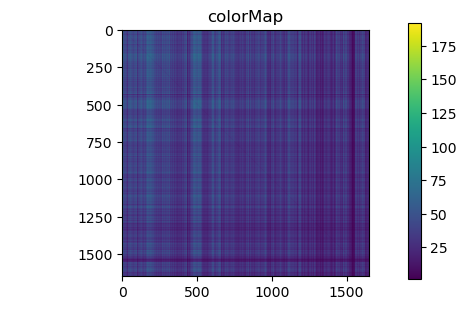

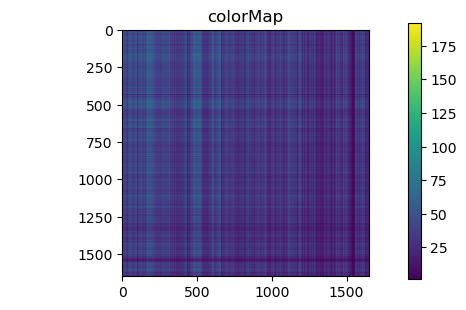

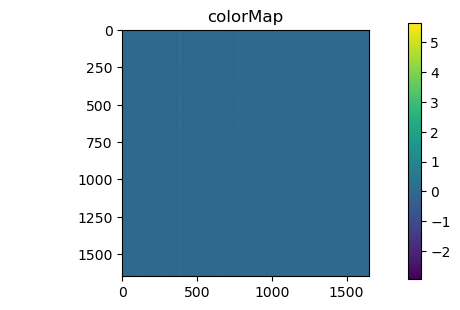

(None, None, None)

In [131]:
func.showColormap(payoffMatrix[0]), func.showColormap(payoffMatrix[1]), func.showColormap(payoffMatrix[1] - payoffMatrix[0])

In [132]:
import pandas as pd
#len(payoffMatrix)
#df[0:1][df == df.iloc[0,0]].isnull().sum().sum()
#값이 다른 8개가 존재함을 알 수 있다.
df1 = pd.DataFrame(payoffMatrix[0])[0:1].sort_values(by=0, axis=1, ascending=False).iloc[0,:_TOP_N_PRUN_]
df2 = pd.DataFrame(payoffMatrix[1])[0:1].sort_values(by=0, axis=1, ascending=False).iloc[0,:_TOP_N_PRUN_]
candidate = (df1.append(df2)).sort_index().index

C:\Users\psh25\AppData\Local\Temp\ipykernel_22076\1696464767.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  candidate = (df1.append(df2)).sort_index().index


In [133]:
pruned_payoff = []
tmp1 = []
tmp2 = []
app1 = []
app2 = []
for i in df1.index :
    tmp1.append(payoffMatrix[0][i][:])
    tmp2.append(payoffMatrix[1][i][:])
for i in df1.index :
    app1.append(np.transpose(tmp1)[i])
    app2.append(np.transpose(tmp2)[i])
    
pruned_payoff.append(np.transpose(app1))
pruned_payoff.append(np.transpose(app2))

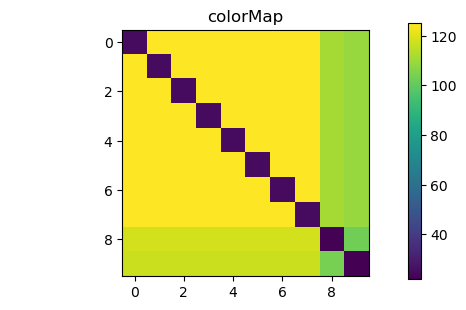

In [136]:
pruned_payoff

df = pd.DataFrame(pruned_payoff[0])
df
func.showColormap(pruned_payoff[0])

In [135]:
game = nashpy.Game(pruned_payoff[0], pruned_payoff[1])
result = next(game.support_enumeration())
result

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))